# Intoduction
In this document the dataset from Kaggle (https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023/) is used to create an ML model to predict a price of a car model. The quality of data is questionable since some of the registration dates of the cars are later than the date of posting. Also, some datepoints are completely useless due to values written in the wrong column or some unplausible data. However, for the purpose of exercise the date seems great.

In [130]:
import pandas as pd
import numpy as np

In [131]:
import math
from sigfig import round as rd_sigfig

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams.update(plt.rcParamsDefault)

In [133]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Importing Data

In [134]:
car_data = pd.read_csv('car_data.csv')

In [135]:
#car_data = car_data[(car_data['brand']=='volkswagen')]

In [136]:
car_data.head(5)

Unnamed: 0       brand              model  color registration_date  year  \
0           0  alfa-romeo     Alfa Romeo GTV    red           10/1995  1995   
1           1  alfa-romeo     Alfa Romeo 164  black           02/1995  1995   
2           2  alfa-romeo  Alfa Romeo Spider  black           02/1995  1995   
3           3  alfa-romeo  Alfa Romeo Spider  black           07/1995  1995   
4           4  alfa-romeo     Alfa Romeo 164    red           11/1996  1996   

  price_in_euro power_kw power_ps transmission_type fuel_type  \
0          1300      148      201            Manual    Petrol   
1         24900      191      260            Manual    Petrol   
2          5900      110      150           Unknown    Petrol   
3          4900      110      150            Manual    Petrol   
4         17950      132      179            Manual    Petrol   

  fuel_consumption_l_100km fuel_consumption_g_km  mileage_in_km  \
0            10,9 l/100 km              260 g/km       160500.0   
1                      NaN              - (g/km)       190000.0   
2                      NaN              - (g/km)       129000.0   
3             9,5 l/100 km              225 g/km       189500.0   
4             7,2 l/100 km              - (g/km)        96127.0   

                       offer_description  
0                              2.0 V6 TB  
1                    Q4 Allrad, 3.2L GTA  
2                          ALFA ROME 916  
3                   2.0 16V Twin Spark L  
4  3.0i Super V6, absoluter Topzustand !

In [137]:
car_data.dtypes

Unnamed: 0                    int64
brand                        object
model                        object
color                        object
registration_date            object
year                         object
price_in_euro                object
power_kw                     object
power_ps                     object
transmission_type            object
fuel_type                    object
fuel_consumption_l_100km     object
fuel_consumption_g_km        object
mileage_in_km               float64
offer_description            object
dtype: object

In [138]:
car_data.isna().sum()

Unnamed: 0                      0
brand                           0
model                           0
color                         166
registration_date               4
year                            0
price_in_euro                   0
power_kw                      134
power_ps                      129
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    26873
fuel_consumption_g_km           0
mileage_in_km                 152
offer_description               1
dtype: int64

# Dropping columns
- "Unnamed: 0" are indices, not useful information.
- "year" is redundant, "registration_date" column already contains the year.
- "power_kw" is redundant, "power_ps" will be used.
- "fuel_consumption_g_km" and "fuel_consumption_l_100km" are redundant and will not be used for fuether analysis since "power_ps", "fuel_type" and "transmission_type" columns already fully describe the car motor. Fuel consumption is a challenging topic to analyze since older cars in general have higher consuption at the same power than newer cars. 
- "offer_description" has some random information as free text and will not be used for further analysis.
- "brand" and "year" columns are used for analysis later in this sheet despite being redundant to the "model" and "registration_date" columns that already contains the brand and are dropped later.

In [139]:
car_data=car_data.drop(columns=\
['Unnamed: 0','power_kw','fuel_consumption_g_km','fuel_consumption_l_100km','offer_description'])

In [140]:
car_data.tail()

brand       model  color registration_date  year price_in_euro  \
251074  volvo  Volvo XC40  white           04/2023  2023         57990   
251075  volvo  Volvo XC90  white           03/2023  2023         89690   
251076  volvo   Volvo V60  white           05/2023  2023         61521   
251077  volvo  Volvo XC40  white           05/2023  2023         57890   
251078  volvo  Volvo XC40   gold           03/2023  2023         52900   

       power_ps transmission_type fuel_type  mileage_in_km  
251074      261         Automatic    Hybrid         1229.0  
251075      235         Automatic    Diesel         4900.0  
251076      197         Automatic    Diesel         1531.0  
251077      179         Automatic    Hybrid         1500.0  
251078      218         Automatic  Electric           50.0

In [141]:
car_data.columns

Index(['brand', 'model', 'color', 'registration_date', 'year', 'price_in_euro',
       'power_ps', 'transmission_type', 'fuel_type', 'mileage_in_km'],
      dtype='object')

# Transforming and Cleaning Data
Since a lot of data entries are false (e.g. year instead horse power or plain text instead of registry year) supposedly from scraping, every entry in every column except 'brand', 'model' and 'color' needs to be verified for format and plausibility. In addition, numerical data needs to be transformed form string to int or float. In this section data is transformed column by colums in the order of appearance in the imported scv file from left to right.

The transformation are performed in a way that each freature is transormed in a float/int or just kept as a string. Also, a condition is formulated for each feature and applied to each datapoint to ensure that the entries are in a realistic range. If the condition is not met, the enrtry is replaced by np.NaN. In the last step of data cleaning all data points containing an np.NAN value are dropped from the dataframe.  

## Brands

**Capitalizing brands and removing "-"**

In [142]:
def brand_name(brand):
    return ' '.join([word.capitalize() for word in brand.split('-')])

In [143]:
car_data['brand'] = car_data['brand'].apply(lambda x: brand_name(x))
car_data

brand              model  color registration_date  year  \
0       Alfa Romeo     Alfa Romeo GTV    red           10/1995  1995   
1       Alfa Romeo     Alfa Romeo 164  black           02/1995  1995   
2       Alfa Romeo  Alfa Romeo Spider  black           02/1995  1995   
3       Alfa Romeo  Alfa Romeo Spider  black           07/1995  1995   
4       Alfa Romeo     Alfa Romeo 164    red           11/1996  1996   
...            ...                ...    ...               ...   ...   
251074       Volvo         Volvo XC40  white           04/2023  2023   
251075       Volvo         Volvo XC90  white           03/2023  2023   
251076       Volvo          Volvo V60  white           05/2023  2023   
251077       Volvo         Volvo XC40  white           05/2023  2023   
251078       Volvo         Volvo XC40   gold           03/2023  2023   

       price_in_euro power_ps transmission_type fuel_type  mileage_in_km  
0               1300      201            Manual    Petrol       160500.0  
1              24900      260            Manual    Petrol       190000.0  
2               5900      150           Unknown    Petrol       129000.0  
3               4900      150            Manual    Petrol       189500.0  
4              17950      179            Manual    Petrol        96127.0  
...              ...      ...               ...       ...            ...  
251074         57990      261         Automatic    Hybrid         1229.0  
251075         89690      235         Automatic    Diesel         4900.0  
251076         61521      197         Automatic    Diesel         1531.0  
251077         57890      179         Automatic    Hybrid         1500.0  
251078         52900      218         Automatic  Electric           50.0  

[251079 rows x 10 columns]

## Models

**Separating the model from manufacturer name and removing datapoints that have no model information (e.g. brand "Mazda", model "Mazda")**

In [144]:
car_data[car_data['model']=='Mazda'].head(3)

brand  model   color registration_date  year price_in_euro power_ps  \
97916  Mazda  Mazda    grey           08/2009  2009          6800      105   
98075  Mazda  Mazda  silver           12/2011  2011         23500       75   
98213  Mazda  Mazda    blue           06/2014  2014         12900      165   

      transmission_type fuel_type  mileage_in_km  
97916            Manual   Unknown       102018.0  
98075            Manual    Petrol       115134.0  
98213            Manual    Petrol       125000.0

In [145]:
def model_name(brand, model):
    brand_split = brand.split() #splitting brands into words
    model_split = sum([word.split(' ') for word in model.split('-')],[]) #splitting models into word and removing "-"
    model_split = [word.capitalize() for word in model_split]
    if brand_split == model_split: #reuturning nan for datapoints having unspecified model, to be filtered out later
        return np.NaN
    else:
        #model_split = [word for word in model_split if word not in brand_split] #remove brand from model
        return ' '.join(model_split) #combining words into single string 

In [146]:
car_data['model'] = car_data.apply(lambda x: model_name(x.brand,x.model), axis=1)
car_data

brand              model  color registration_date  year  \
0       Alfa Romeo     Alfa Romeo Gtv    red           10/1995  1995   
1       Alfa Romeo     Alfa Romeo 164  black           02/1995  1995   
2       Alfa Romeo  Alfa Romeo Spider  black           02/1995  1995   
3       Alfa Romeo  Alfa Romeo Spider  black           07/1995  1995   
4       Alfa Romeo     Alfa Romeo 164    red           11/1996  1996   
...            ...                ...    ...               ...   ...   
251074       Volvo         Volvo Xc40  white           04/2023  2023   
251075       Volvo         Volvo Xc90  white           03/2023  2023   
251076       Volvo          Volvo V60  white           05/2023  2023   
251077       Volvo         Volvo Xc40  white           05/2023  2023   
251078       Volvo         Volvo Xc40   gold           03/2023  2023   

       price_in_euro power_ps transmission_type fuel_type  mileage_in_km  
0               1300      201            Manual    Petrol       160500.0  
1              24900      260            Manual    Petrol       190000.0  
2               5900      150           Unknown    Petrol       129000.0  
3               4900      150            Manual    Petrol       189500.0  
4              17950      179            Manual    Petrol        96127.0  
...              ...      ...               ...       ...            ...  
251074         57990      261         Automatic    Hybrid         1229.0  
251075         89690      235         Automatic    Diesel         4900.0  
251076         61521      197         Automatic    Diesel         1531.0  
251077         57890      179         Automatic    Hybrid         1500.0  
251078         52900      218         Automatic  Electric           50.0  

[251079 rows x 10 columns]

**Sorting models alphabetically**

In [147]:
car_data = car_data.sort_values(by='model')

In [148]:
car_data[car_data['model']=='Mazda'].head(3)

Empty DataFrame
Columns: [brand, model, color, registration_date, year, price_in_euro, power_ps, transmission_type, fuel_type, mileage_in_km]
Index: []

In [149]:
car_data[car_data['brand']=='Mazda'].head(3)

brand    model  color registration_date  year price_in_euro power_ps  \
101177  Mazda  Mazda 2  black           03/2022  2022         23490       92   
98415   Mazda  Mazda 2  black           09/2015  2015         10900       75   
101179  Mazda  Mazda 2  black           01/2022  2022         18541       90   

       transmission_type fuel_type  mileage_in_km  
101177         Automatic    Hybrid         3202.0  
98415             Manual    Petrol        18314.0  
101179            Manual    Petrol         4500.0

In [150]:
car_data['model'].unique()

array(['Alfa Romeo 145', 'Alfa Romeo 146', 'Alfa Romeo 147', ...,
       'Volvo Xc70', 'Volvo Xc90', nan], dtype=object)

## Registration Date
The 'registration_date' column is transformed into the 'car_age' column since the car age is concidered more useful for the analysis. The 'registration_date' column is dropped afterwards.

In [151]:
car_data.head(3)

brand           model color registration_date  year price_in_euro  \
19  Alfa Romeo  Alfa Romeo 145   red           03/1997  1997         11990   
57  Alfa Romeo  Alfa Romeo 145   red           01/2000  2000          3480   
6   Alfa Romeo  Alfa Romeo 145   red           12/1996  1996          3500   

   power_ps transmission_type fuel_type  mileage_in_km  
19      120            Manual    Petrol       124963.0  
57      120            Manual    Petrol       128000.0  
6       150            Manual    Petrol       230000.0

In [152]:
def car_age(date_format,end_date,date):
    try:
        delta = datetime.strptime(end_date,date_format) - datetime.strptime(date,date_format)
        delta_years = round(delta.days/365, ndigits=1)
        if delta_years < 0:
            return np.NaN
        else:
            return delta_years
    except:
        return np.NaN

In [153]:
date_format = '%m/%Y'
end_date = '06/2023' #Dataset last updated in June according to Kaggle
car_data['car_age'] = car_data['registration_date'].apply(lambda date: car_age(date_format,end_date,date))

In [154]:
car_data.head(3)

brand           model color registration_date  year price_in_euro  \
19  Alfa Romeo  Alfa Romeo 145   red           03/1997  1997         11990   
57  Alfa Romeo  Alfa Romeo 145   red           01/2000  2000          3480   
6   Alfa Romeo  Alfa Romeo 145   red           12/1996  1996          3500   

   power_ps transmission_type fuel_type  mileage_in_km  car_age  
19      120            Manual    Petrol       124963.0     26.3  
57      120            Manual    Petrol       128000.0     23.4  
6       150            Manual    Petrol       230000.0     26.5

In [155]:
car_data = car_data.drop(columns=['year','registration_date'])

In [156]:
car_data = car_data.drop_duplicates()

## Price
The 'price_in_euro' column entries are strings and are transformed into integer for further analysis.

In [157]:
#car_data.sort_values(by=['price_in_euro'],ascending=False).head()

In [158]:
def transform_price(price):
    try:
        return int(price)
    except:
        return np.NaN

In [159]:
car_data['price_in_euro'] = \
car_data['price_in_euro'].apply(lambda price: transform_price(price))

## Horse Power
The 'power_ps' column entries are strings and are transformed into integer for further analysis.

In [160]:
def transform_hp(hp):
    try:
        hp = int(hp)
        if hp > 1000:
            return np.NaN
        else:
            return hp
    except:
        return np.NaN

In [161]:
car_data['power_ps'] = \
car_data['power_ps'].apply(lambda hp: transform_hp(hp))

## Transmission Type

In [162]:
#car_data['transmission_type'].value_counts()

In [163]:
def transform_transmission(transmission):
    if transmission == 'Unknown':
        return np.NaN
    elif transmission == 'Semi-automatic':
        return 'Automatic'
    else:
        return transmission

In [164]:
car_data['transmission_type'] = \
car_data['transmission_type'].apply(lambda transmission: transform_transmission(transmission))

In [165]:
#car_data['transmission_type'].value_counts()

## Fuel Type

In [166]:
fuels = ['Petrol','Diesel','Hybrid','Electric','LPG','CNG','Diesel Hybrid','Hydrogen']

In [167]:
def transform_fuel(fuel):
    if fuel in fuels:
        return fuel
    else:
        return np.NaN

In [168]:
car_data['fuel_type'] = \
car_data['fuel_type'].apply(lambda fuel: transform_fuel(fuel))

In [169]:
#car_data['fuel_type'].value_counts()

## Mileage
Mileage data is transformed into float and all car having a mileage over 500.000 km are dropped. Values above are rare and and make it difficult to obtain enough data to create a robust ML model.

In [170]:
car_data.dtypes

brand                 object
model                 object
color                 object
price_in_euro        float64
power_ps             float64
transmission_type     object
fuel_type             object
mileage_in_km        float64
car_age              float64
dtype: object

In [171]:
#car_data.sort_values(by=['mileage_in_km'],ascending=False).head(500)

In [172]:
def transform_mileage(mileage):
    try:
        mileage = int(mileage)
        if mileage < 500000:
            return mileage
        else:
            return np.NaN
    except:
        return np.NaN

In [173]:
# car_data['mileage_in_km'] = \
# car_data['mileage_in_km'].apply(lambda mileage: transform_mileage(mileage))

In [174]:
car_data.loc[:,('mileage_in_km')] = car_data.loc[:,('mileage_in_km')].apply(lambda mileage: transform_mileage(mileage))

In [175]:
car_data.sort_values(by=['mileage_in_km'],ascending=False).head(5)

brand                 model   color  price_in_euro  power_ps  \
109798  Mercedes Benz  Mercedes Benz Ml 450   black         9999.0     306.0   
53473            Fiat           Fiat Ducato     red         9900.0     177.0   
169033        Renault       Renault Mascott     red         7990.0     129.0   
218329     Volkswagen    Volkswagen Crafter  silver        10000.0     109.0   
177837           Seat         Seat Alhambra   white        10999.0     140.0   

       transmission_type fuel_type  mileage_in_km  car_age  
109798         Automatic    Diesel       499990.0     12.8  
53473             Manual    Diesel       499000.0      7.6  
169033            Manual    Diesel       499000.0     14.8  
218329            Manual    Diesel       498764.0     16.1  
177837         Automatic    Diesel       498140.0     10.9

## NaN values

### Sums per feature

In [176]:
car_data.isna().sum()

brand                   0
model                2103
color                  84
price_in_euro         184
power_ps              226
transmission_type    1140
fuel_type             465
mileage_in_km         277
car_age               188
dtype: int64

### Percentage of NaNs per feature

In [177]:
car_data.isna().sum()/len(car_data)*100

brand                0.000000
model                0.863130
color                0.034476
price_in_euro        0.075519
power_ps             0.092757
transmission_type    0.467888
fuel_type            0.190849
mileage_in_km        0.113689
car_age              0.077160
dtype: float64

In [178]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243648 entries, 19 to 250953
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              243648 non-null  object 
 1   model              241545 non-null  object 
 2   color              243564 non-null  object 
 3   price_in_euro      243464 non-null  float64
 4   power_ps           243422 non-null  float64
 5   transmission_type  242508 non-null  object 
 6   fuel_type          243183 non-null  object 
 7   mileage_in_km      243371 non-null  float64
 8   car_age            243460 non-null  float64
dtypes: float64(4), object(5)
memory usage: 18.6+ MB


### Overview of NaN values

In [179]:
car_data_nona = car_data.dropna()

In [180]:
car_data_nona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239605 entries, 19 to 248028
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              239605 non-null  object 
 1   model              239605 non-null  object 
 2   color              239605 non-null  object 
 3   price_in_euro      239605 non-null  float64
 4   power_ps           239605 non-null  float64
 5   transmission_type  239605 non-null  object 
 6   fuel_type          239605 non-null  object 
 7   mileage_in_km      239605 non-null  float64
 8   car_age            239605 non-null  float64
dtypes: float64(4), object(5)
memory usage: 18.3+ MB


In [181]:
car_data_nona.isna().sum()

brand                0
model                0
color                0
price_in_euro        0
power_ps             0
transmission_type    0
fuel_type            0
mileage_in_km        0
car_age              0
dtype: int64

### Percentage of data with NaN values in the dataset

In [182]:
np.round(len(car_data_nona)/len(car_data)*100,decimals=1)

98.3

### Dropping NaN values

In [183]:
car_data = car_data_nona

In [184]:
car_data.isna().sum()

brand                0
model                0
color                0
price_in_euro        0
power_ps             0
transmission_type    0
fuel_type            0
mileage_in_km        0
car_age              0
dtype: int64

## Dropping rare model variants
Some model variants are very rare and cause problems during fitting the ML algorithm. E.g. if a model has only one CNG fueled car and is present in the training set or test set only. Therefore, these rare combinations need to be filtered out of the dataset. A model combination is defined by the features 'model','power_ps','transmission_type','fuel_type'. 

The filtering works as follows.
- Create a dataframe the contains the model defining features only (model_combos).
- Define a minimum amount of occurances of a model combination in dataset. 
- Count the number of occurneces for each combination.
- Filter out the minor model cobinations the number of occurances thereof is lower than the defined minimum amount, create a dataframe for that (minor_model_combos)
- Find out which index labels in model_combos (same as original car_data!) belong to the minor_model_combos (perform the left join without the inner join)
- Filter out the minor models from the car_data based using the obtain indices.

**Checking for rare variants in remaining dataset.**

In [185]:
car_data['model'].value_counts()

model
Volkswagen Golf        7475
Opel Astra             4177
Opel Corsa             4093
Seat Leon              3986
Ford Focus             3775
                       ... 
Infiniti M35              1
Infiniti M30              1
Renault Latitude          1
Ferrari Mondial           1
Mercedes Benz S 280       1
Name: count, Length: 1269, dtype: int64

In [186]:
model_combos = car_data[['model','power_ps','transmission_type','fuel_type']]

In [187]:
model_combos_counts = car_data[['model','power_ps','transmission_type','fuel_type']].value_counts()
model_combos_counts

model          power_ps  transmission_type  fuel_type
Fiat 500       69.0      Manual             Petrol       988
Opel Corsa     101.0     Manual             Petrol       878
Ford Focus     125.0     Manual             Petrol       739
Ford Kuga      150.0     Manual             Petrol       645
Skoda Octavia  150.0     Automatic          Diesel       640
                                                        ... 
Ford Mustang   426.0     Automatic          Petrol         1
Renault Clio   143.0     Automatic          Hybrid         1
               145.0     Automatic          Petrol         1
Ford Mustang   424.0     Automatic          Petrol         1
Volvo Xc90     455.0     Automatic          Petrol         1
Name: count, Length: 12071, dtype: int64

**Defining minimum number of occurances**

In [188]:
min_combos = 3

In [189]:
minor_model_combos = model_combos_counts[model_combos_counts<min_combos]
minor_model_combos = minor_model_combos.reset_index()
minor_model_combos.drop(columns='count',inplace=True)
minor_model_combos

model  power_ps transmission_type fuel_type
0     Porsche Boxster     260.0            Manual    Petrol
1        Lancia Lybra     150.0            Manual    Petrol
2         Hyundai I20     101.0            Manual    Hybrid
3         Hyundai I20      90.0            Manual    Diesel
4            Audi Rs6     700.0         Automatic    Petrol
...               ...       ...               ...       ...
4915     Ford Mustang     426.0         Automatic    Petrol
4916     Renault Clio     143.0         Automatic    Hybrid
4917     Renault Clio     145.0         Automatic    Petrol
4918     Ford Mustang     424.0         Automatic    Petrol
4919       Volvo Xc90     455.0         Automatic    Petrol

[4920 rows x 4 columns]

In [190]:
#print(len(car_data))
#print(len(minor_model_combos))
print(f'Rare model variants are {np.round(len(minor_model_combos)/len(car_data)*100,decimals=1)} % from the whole dataset')

Rare model variants are 2.1 % from the whole dataset


**Performing the left join without the inner join: finding out which indices in car_data correspond to rare models in minor_model_combos**

In [191]:
df_merge = pd.merge(model_combos, minor_model_combos, on=model_combos.columns.to_list(), how="left", indicator=True)
df_merge.index = model_combos.index ##copying index labels from original dataset
df_merge = df_merge.query('_merge=="both"')
df_merge.drop(columns=['_merge'],inplace=True)

**Dropping rare models variants using the obtain index labels**

In [192]:
car_data = car_data.drop(labels=df_merge.index.to_list())
car_data

brand           model  color  price_in_euro  power_ps  \
19      Alfa Romeo  Alfa Romeo 145    red        11990.0     120.0   
57      Alfa Romeo  Alfa Romeo 145    red         3480.0     120.0   
48      Alfa Romeo  Alfa Romeo 145  black         1100.0     120.0   
205     Alfa Romeo  Alfa Romeo 147  black         1250.0     105.0   
149     Alfa Romeo  Alfa Romeo 147    red         2999.0     105.0   
...            ...             ...    ...            ...       ...   
247616       Volvo      Volvo Xc90   grey        37880.0     235.0   
250470       Volvo      Volvo Xc90  black        61900.0     235.0   
250472       Volvo      Volvo Xc90  black        59850.0     235.0   
247635       Volvo      Volvo Xc90   grey        27900.0     235.0   
248028       Volvo      Volvo Xc90   grey        32900.0     235.0   

       transmission_type fuel_type  mileage_in_km  car_age  
19                Manual    Petrol       124963.0     26.3  
57                Manual    Petrol       128000.0     23.4  
48                Manual    Petrol       205000.0     24.3  
205               Manual    Petrol        85000.0     16.9  
149               Manual    Petrol       171000.0     17.8  
...                  ...       ...            ...      ...  
247616         Automatic    Diesel       120000.0      6.2  
250470         Automatic    Diesel        23000.0      2.3  
250472         Automatic    Diesel        31478.0      1.7  
247635         Automatic    Diesel        70000.0      6.4  
248028         Automatic    Diesel       175348.0      4.6  

[233449 rows x 9 columns]

**Checking for rare variants in remaining dataset, the least amount of occurarance should be above minimum.** 

In [193]:
car_data[['model','power_ps','transmission_type','fuel_type']].value_counts()

model               power_ps  transmission_type  fuel_type
Fiat 500            69.0      Manual             Petrol       988
Opel Corsa          101.0     Manual             Petrol       878
Ford Focus          125.0     Manual             Petrol       739
Ford Kuga           150.0     Manual             Petrol       645
Skoda Octavia       150.0     Automatic          Diesel       640
                                                             ... 
Hyundai Kona        141.0     Automatic          Petrol         3
Volkswagen Cc       211.0     Automatic          Petrol         3
Volkswagen Crafter  109.0     Automatic          Diesel         3
Hyundai Ix20        90.0      Manual             Diesel         3
Alfa Romeo 145      120.0     Manual             Petrol         3
Name: count, Length: 7151, dtype: int64

## Dropping variants of models that have less than a defined amount of occurances in the dataset

In [194]:
min_models = 15
model_counts = car_data['model'].value_counts()
major_models = model_counts[model_counts.values > min_models].keys().tolist()
car_data = car_data[car_data['model'].isin(major_models)]
car_data['model'].value_counts()

model
Volkswagen Golf        7422
Opel Astra             4142
Opel Corsa             4078
Seat Leon              3964
Ford Focus             3748
                       ... 
Alfa Romeo 156           16
Renault Wind             16
Mercedes Benz R 500      16
Volvo Xc70               16
Mazda Cx 7               16
Name: count, Length: 753, dtype: int64

## Checking columns dtypes

In [195]:
car_data.dtypes

brand                 object
model                 object
color                 object
price_in_euro        float64
power_ps             float64
transmission_type     object
fuel_type             object
mileage_in_km        float64
car_age              float64
dtype: object

## Correcting dtypes

In [196]:
car_data = car_data.astype({'price_in_euro': 'int',
                            'power_ps':'int',
                            'mileage_in_km':'int',
                })

In [197]:
car_data.dtypes

brand                 object
model                 object
color                 object
price_in_euro          int64
power_ps               int64
transmission_type     object
fuel_type             object
mileage_in_km          int64
car_age              float64
dtype: object

# Data Exploration

## Continuous Features

### Correlation between continuous features

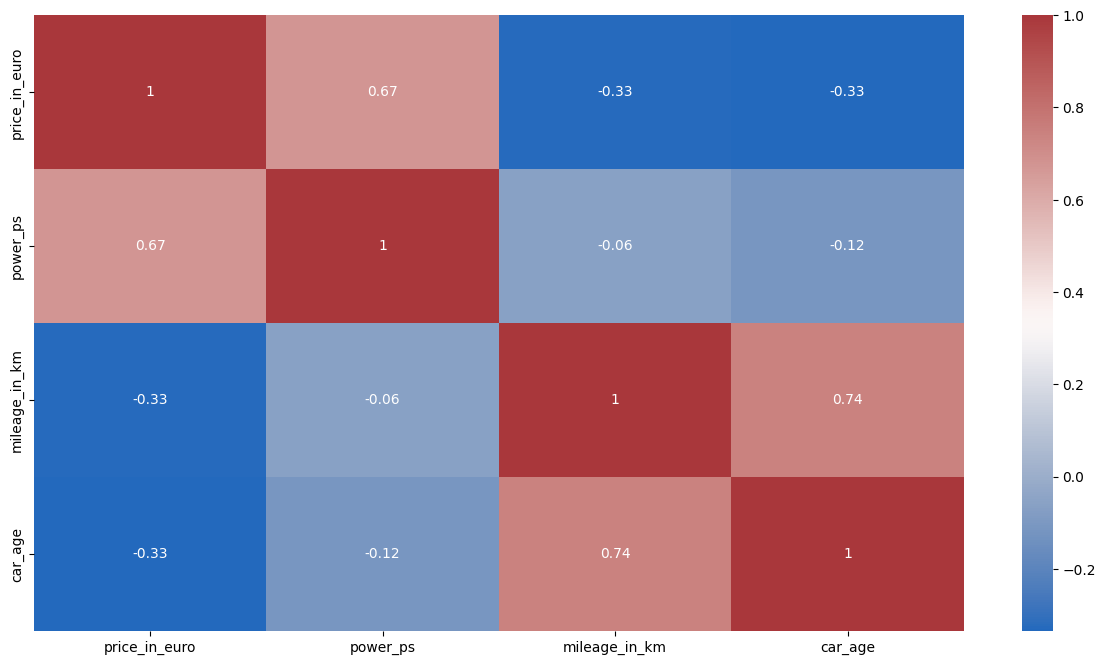

In [198]:
plt.figure(figsize=(15,8))
sns.heatmap(car_data[['price_in_euro','power_ps','mileage_in_km','car_age']].corr(),annot=True,cmap='vlag')
plt.show()

**It can be seen that all of the remaining continuous features have a significant influence on the price**

### Prices distribution

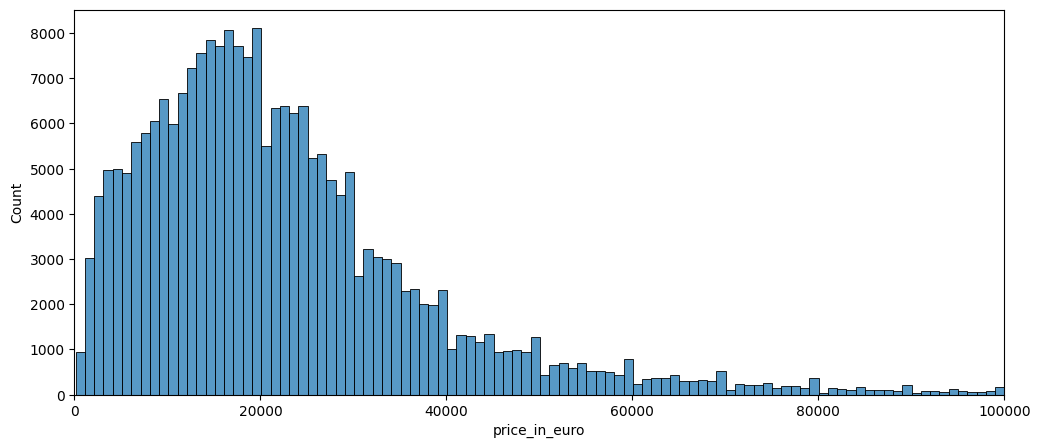

In [199]:
plt.figure(figsize=(12,5))
sns.histplot(data=car_data[car_data['price_in_euro']<100000],x='price_in_euro',bins=100)
plt.xlim(0, 100000)
plt.show()

### Mileage distribution

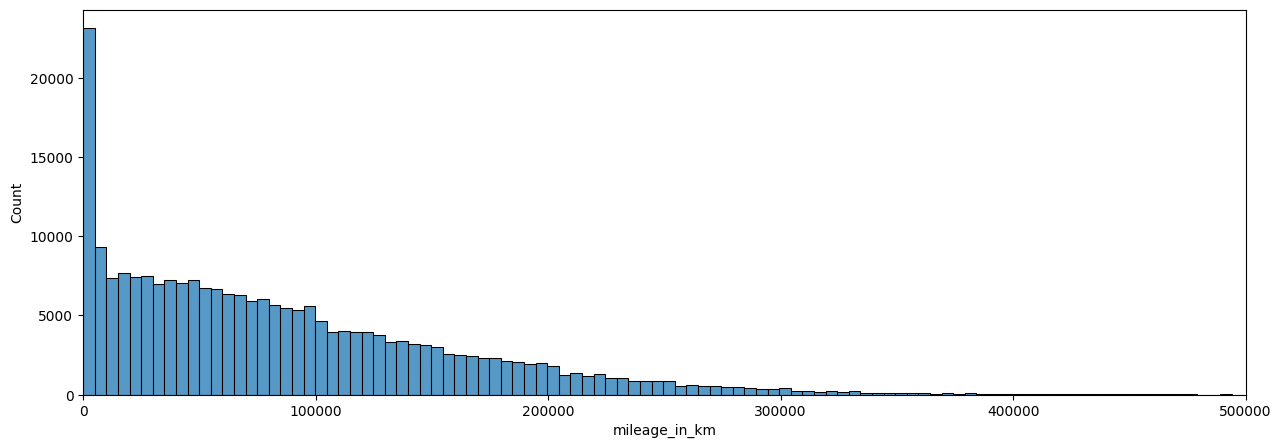

In [200]:
plt.figure(figsize=(15,5))
sns.histplot(data=car_data,x='mileage_in_km',bins=100,)
plt.xlim(0, 500000)
plt.show()

### Age distribution

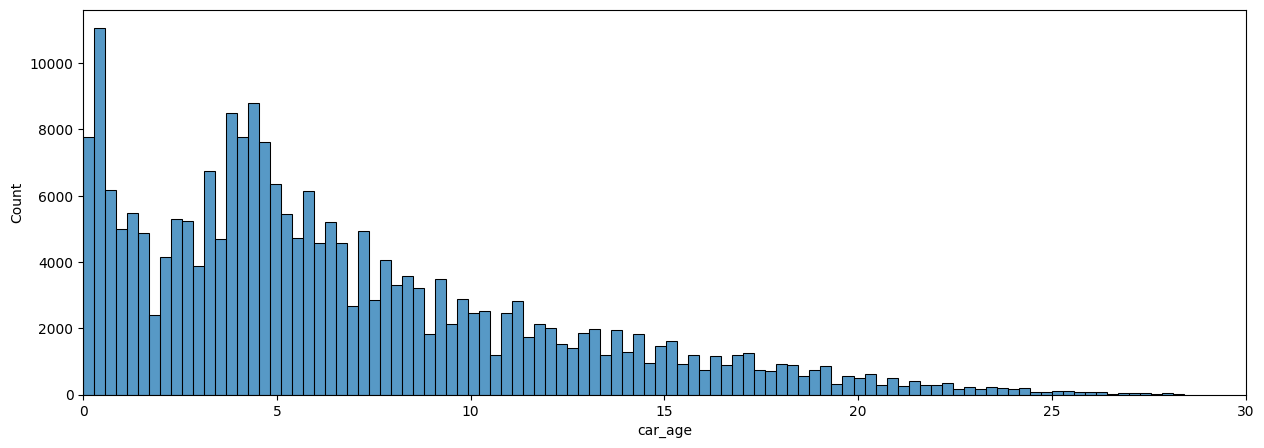

In [201]:
plt.figure(figsize=(15,5))
sns.histplot(data=car_data,x='car_age',bins=100,)
plt.xlim(0, 30)
plt.show()

### Horsepower vs price

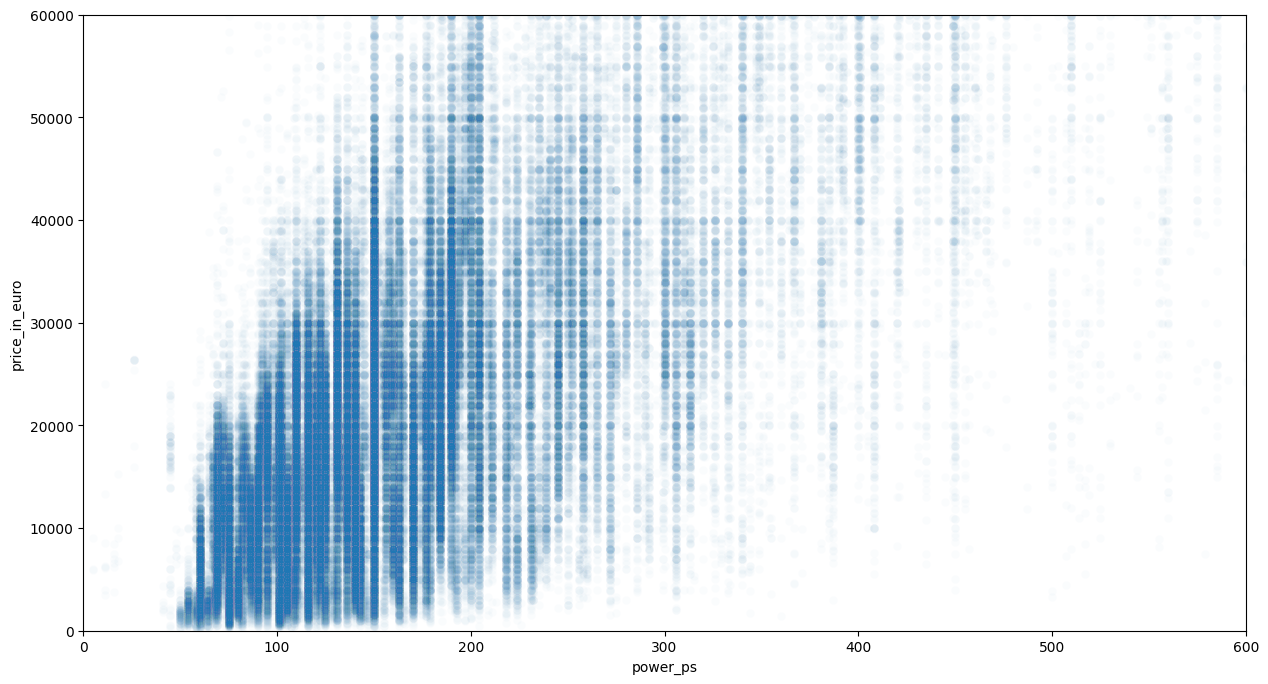

In [202]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=car_data,x='power_ps',y='price_in_euro',alpha=0.02)
plt.xlim(0, 600)
plt.ylim(0, 60000)
plt.show()

**There is a trend between the power and price, but less clear as seen in the correlation plot**

### Horsepower vs mileage and price

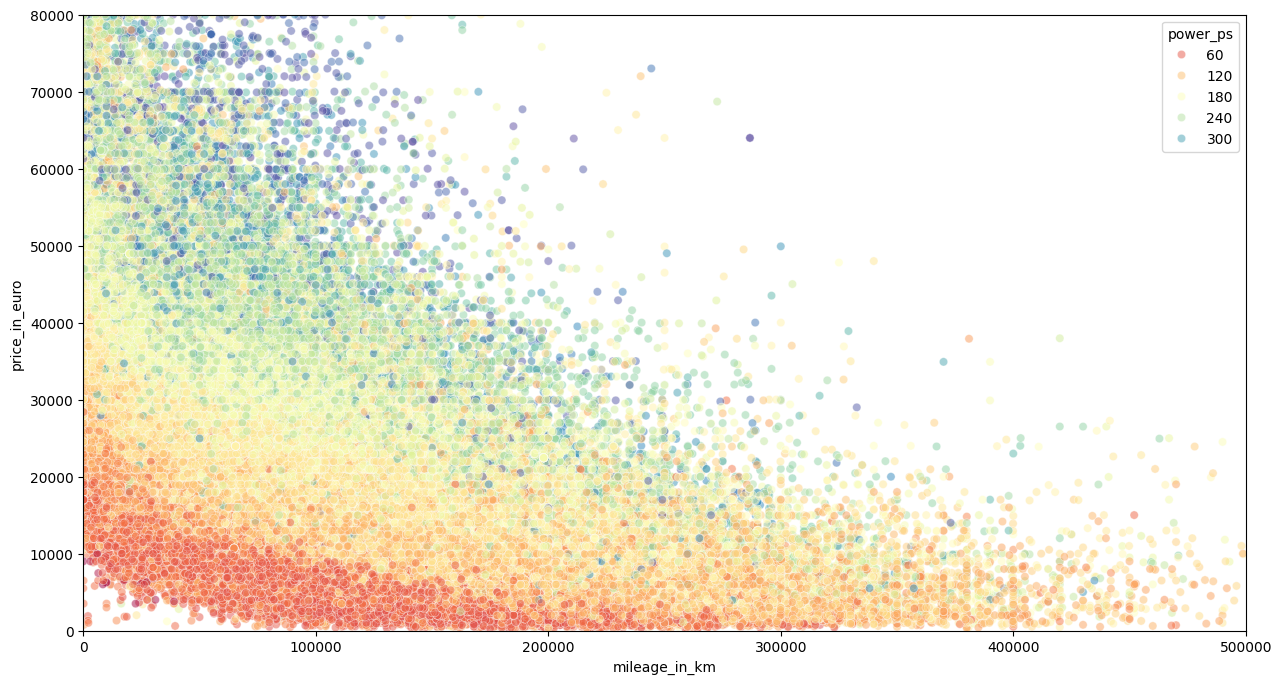

In [203]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=car_data[car_data['power_ps']<350],x='mileage_in_km',y='price_in_euro', hue='power_ps',alpha=0.5, palette='Spectral')
plt.xlim(0, 500000)
plt.ylim(0, 80000)
plt.show()

**In this plot the dependence between the power and price is more apparent with lower powered models occupy the region with the lower prices.**

### Car age vs price

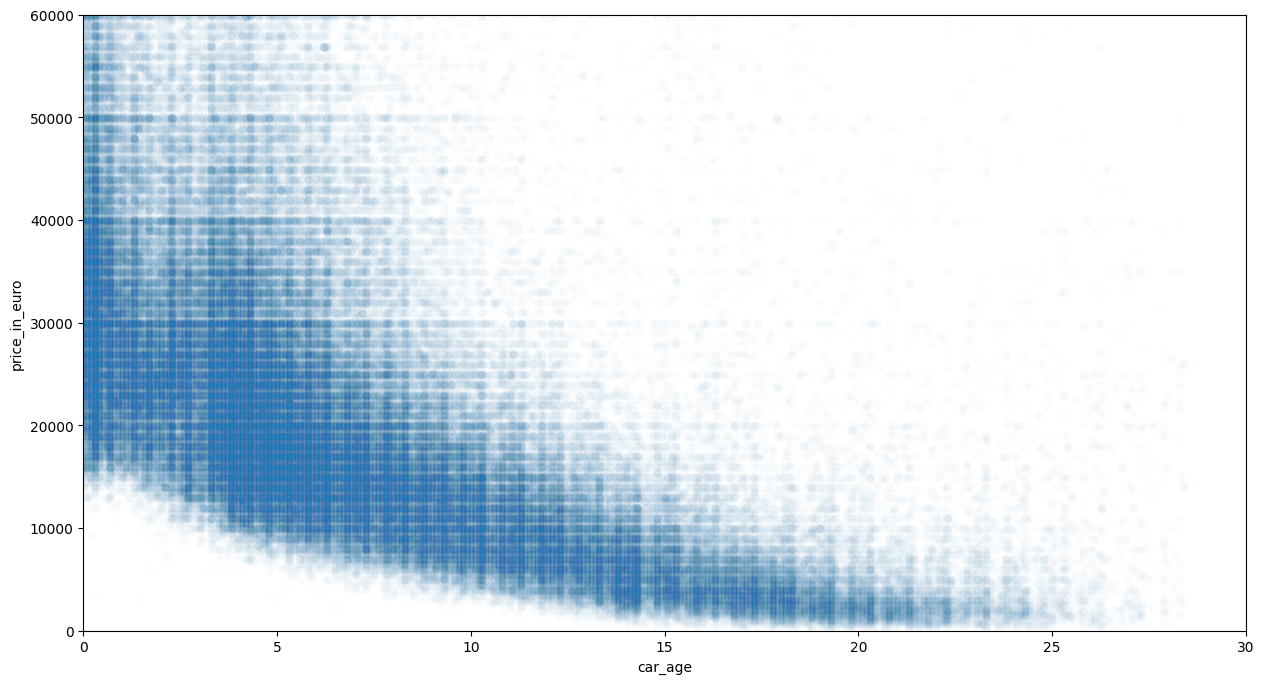

In [204]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=car_data,x='car_age',y='price_in_euro',alpha=0.02)
plt.xlim(0, 30)
plt.ylim(0, 60000)
plt.show()

**There is a strong dependence between the age and price, but less clear as seen in the correlation plot**

### Mileage vs price

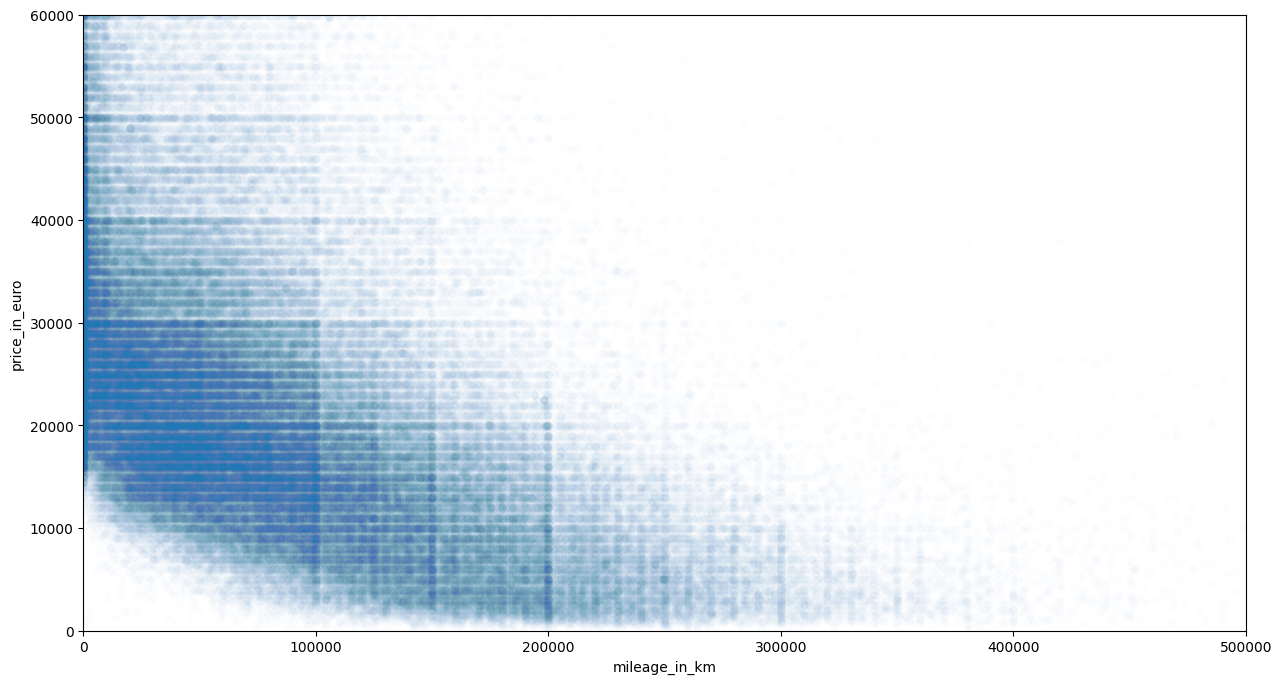

In [205]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=car_data,x='mileage_in_km',y='price_in_euro',alpha=0.01)
plt.xlim(0, 500000)
plt.ylim(0, 60000)
plt.show()

**There is a strong dependence between the mileage and price, but less clear as seen in the correlation plot**

## Categorical Features

### Color

In [206]:
color_data = car_data['color'].value_counts(normalize=True)
colors = car_data['color'].value_counts(normalize=True).keys()
color_data

color
black     0.234716
grey      0.187890
white     0.160987
silver    0.137691
blue      0.127306
red       0.084623
brown     0.017797
green     0.013564
orange    0.013110
beige     0.009145
yellow    0.007002
bronze    0.002307
gold      0.002298
violet    0.001564
Name: proportion, dtype: float64

In [207]:
explode_values = 10**-3/color_data.values*2
explode_values

array([0.00852094, 0.01064452, 0.01242337, 0.0145253 , 0.01571016,
       0.0236342 , 0.11237718, 0.14745032, 0.15255157, 0.21870288,
       0.28562246, 0.86702996, 0.87028947, 1.27898895])

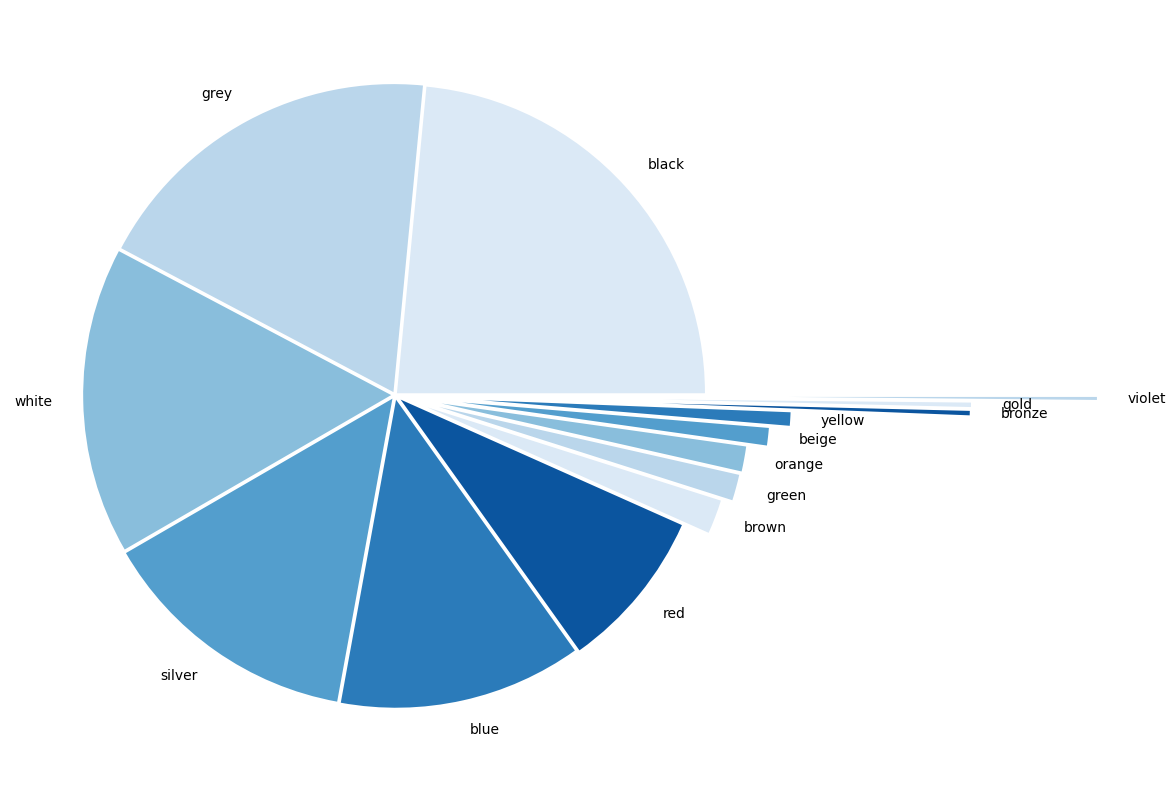

In [208]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(color_data,labels=colors,explode=explode_values,radius=1,colors=sns.color_palette('Blues'))
plt.show()

### Fuel Kind

In [209]:
fuel_data = car_data['fuel_type'].value_counts(normalize=True)
colors = car_data['fuel_type'].value_counts(normalize=True).keys()
explode_values = 10**-3/fuel_data.values**(5/6)

explode_values

array([0.00158767, 0.00240786, 0.01257993, 0.02352315, 0.12758436,
       0.18482284, 0.20388381, 0.82734267])

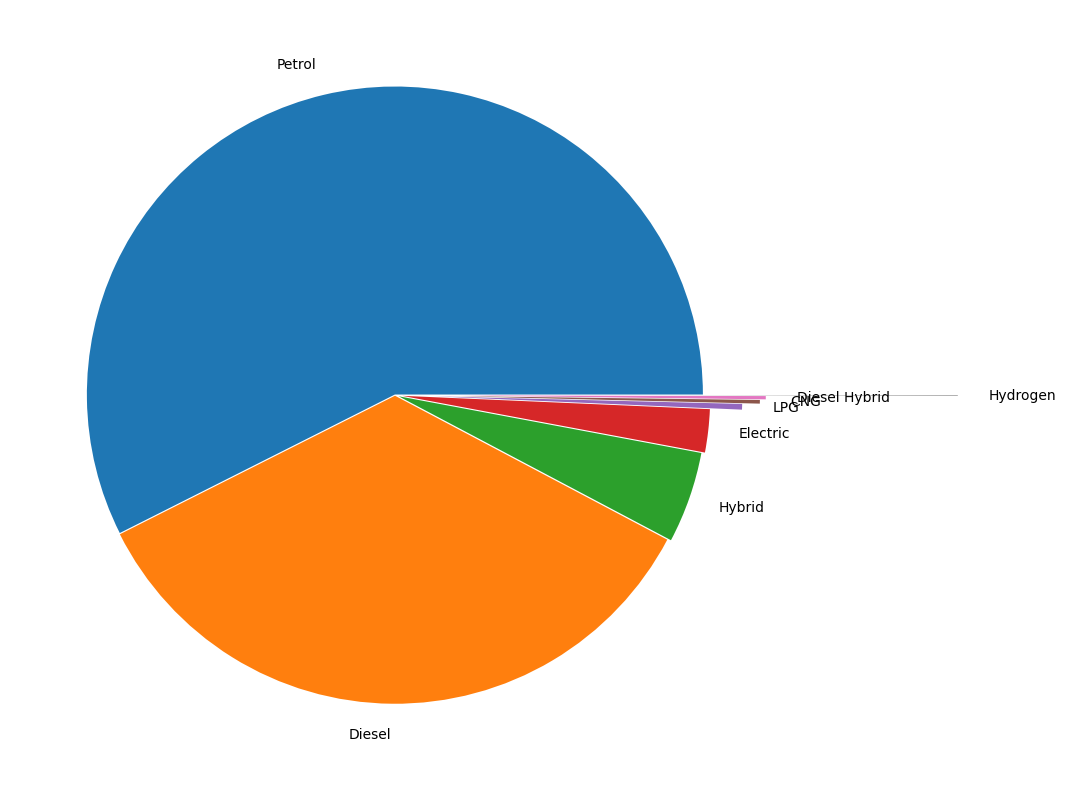

In [210]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(fuel_data,labels=colors,explode=explode_values,radius=1)
plt.show()

### Transmission Kind

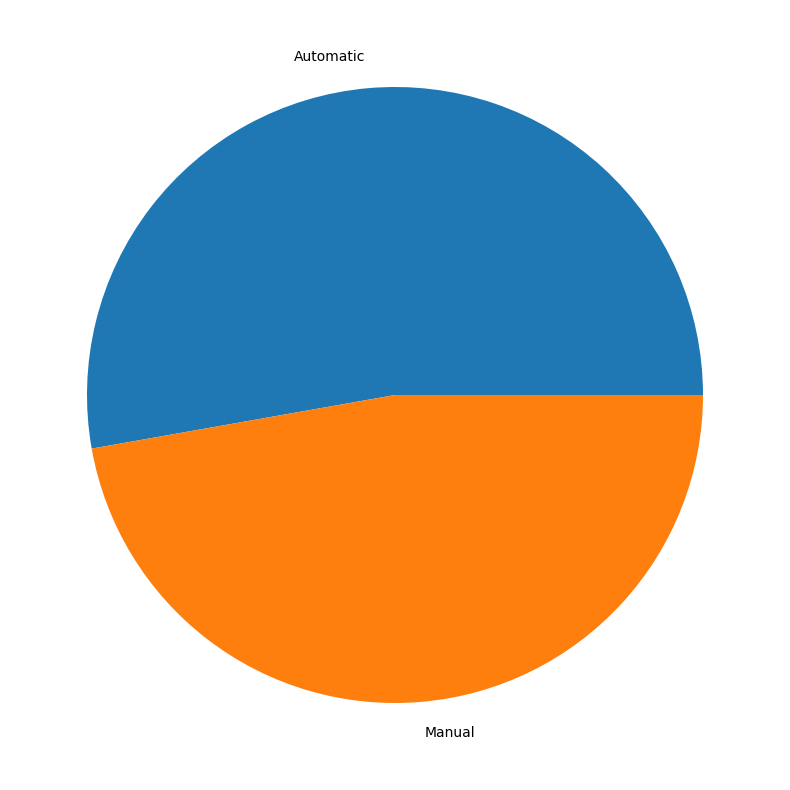

In [211]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(car_data['transmission_type'].value_counts(normalize=True),
       labels=car_data['transmission_type'].value_counts(normalize=True).keys())
plt.show()

**For a better evaluation of the categorical features, a single brand "Volkswagen" is used for the following.** 

In [212]:
car_data_select = car_data[car_data['brand']=='Volkswagen']        

### Fuel type vs mileage and price

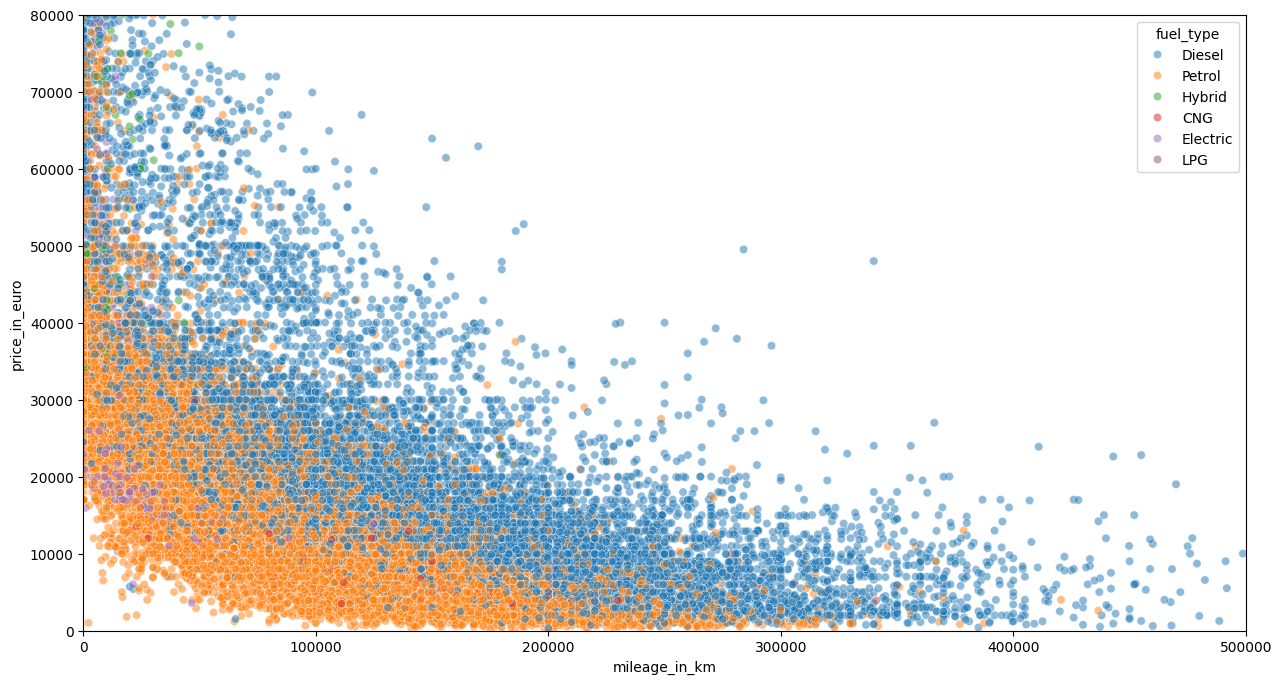

In [213]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=car_data_select,x='mileage_in_km',y='price_in_euro', hue='fuel_type',alpha=0.5)
plt.xlim(0, 500000)
plt.ylim(0, 80000)
plt.show()

**It can be seen that fuel type has a signicant effect on the price, petrol fuels models occupy the region with lower prices.**  

### Transmission type vs mileage and price

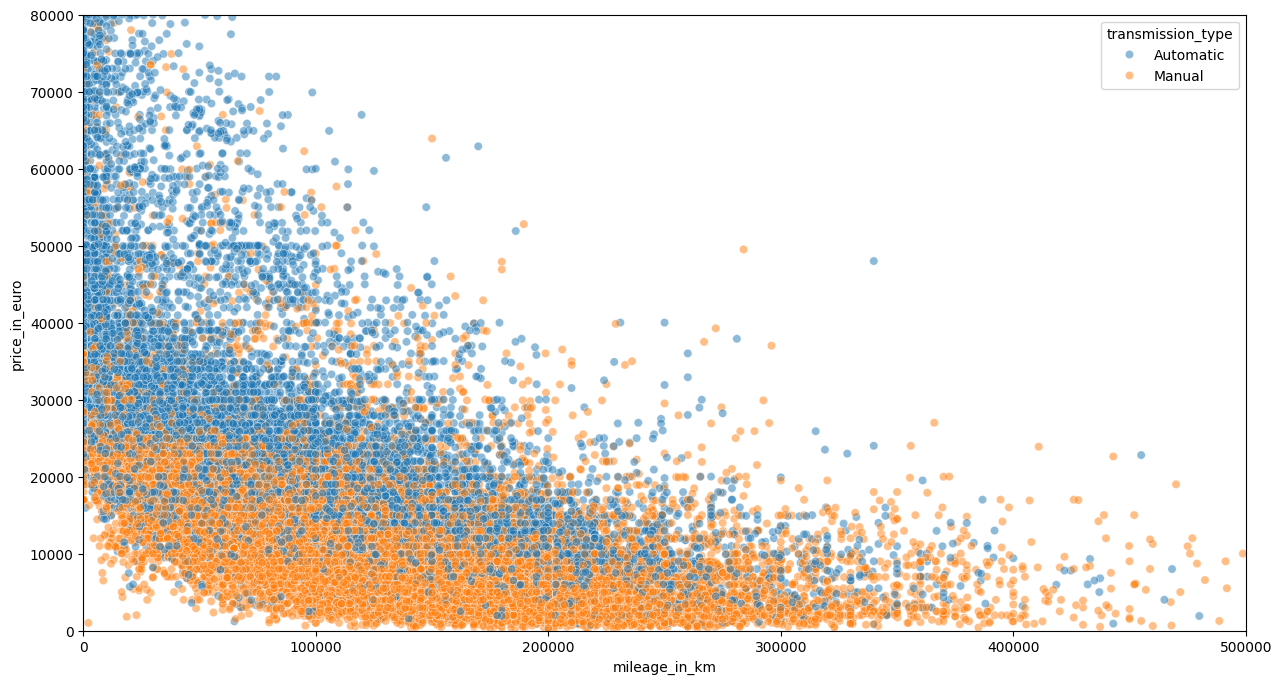

In [214]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=car_data_select,x='mileage_in_km',y='price_in_euro', hue='transmission_type',alpha=0.5)
plt.xlim(0, 500000)
plt.ylim(0, 80000)
plt.show()

**Transmission type has  also a signicant effect on the price, manual transmission models occupy the region with lower prices.**

### Color vs mileage and price

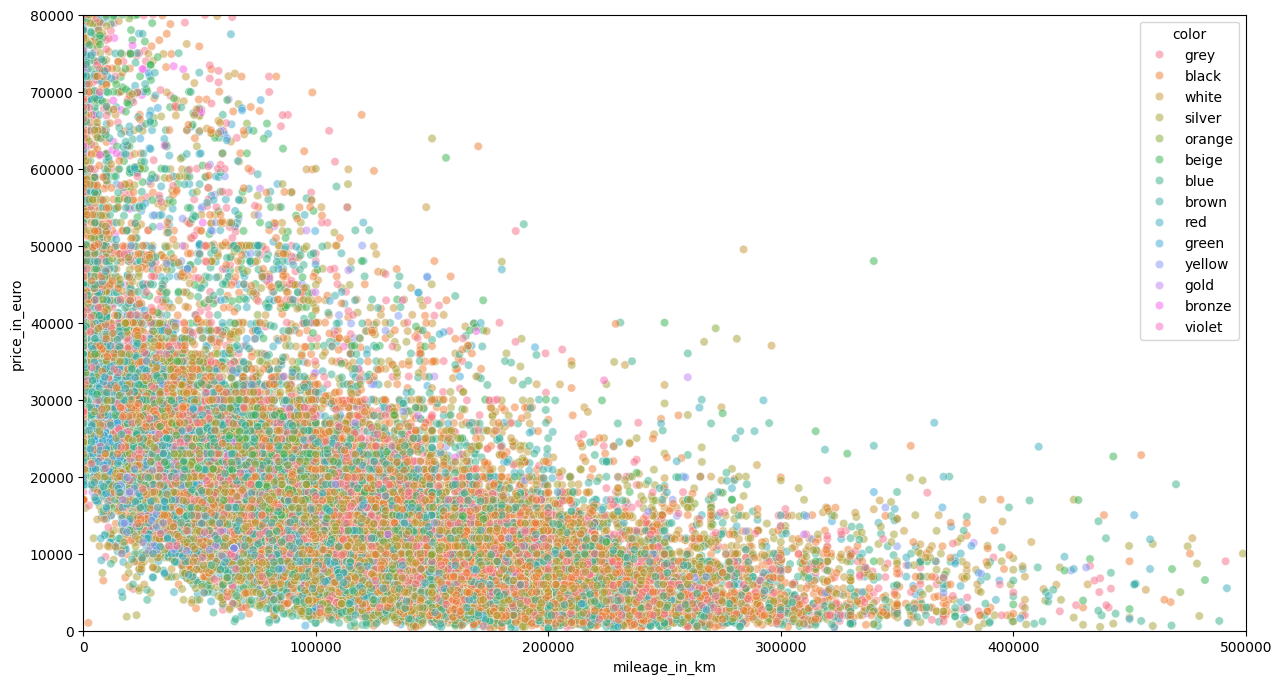

In [215]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=car_data_select,x='mileage_in_km',y='price_in_euro', hue='color',alpha=0.5)
plt.xlim(0, 500000)
plt.ylim(0, 80000)
plt.show()

**Since there is no visible evidence that colors influence the price of the car, this feature is dropped**

In [216]:
car_data.drop(columns=['color'],inplace=True)

## Rankings 

### Models with highest amount of occurances

In [217]:
pd.DataFrame(car_data['model'].value_counts()).head(10)

count
model                 
Volkswagen Golf   7422
Opel Astra        4142
Opel Corsa        4078
Seat Leon         3964
Ford Focus        3748
Skoda Octavia     3641
Audi A3           3424
Audi A4           3283
Volkswagen Polo   3057
Audi A6           2803

### Models with highest amount of occurances having the same power_ps, transmission_type, fuel_type

In [218]:
pd.DataFrame(car_data[['model','power_ps','transmission_type','fuel_type']].value_counts()).head(10)#.columns#.sort_values(by='0')

count
model               power_ps transmission_type fuel_type       
Fiat 500            69       Manual            Petrol       988
Opel Corsa          101      Manual            Petrol       878
Ford Focus          125      Manual            Petrol       739
Ford Kuga           150      Manual            Petrol       645
Seat Ateca          150      Automatic         Petrol       640
Skoda Octavia       150      Automatic         Diesel       640
Skoda Fabia         95       Manual            Petrol       628
Mercedes Benz C 220 170      Automatic         Diesel       581
Toyota Yaris        116      Automatic         Hybrid       564
Mercedes Benz C 180 156      Automatic         Petrol       545

### Creating a table with mean and relative standard deviation for each model

In [219]:
car_data

brand           model  price_in_euro  power_ps transmission_type  \
205     Alfa Romeo  Alfa Romeo 147           1250       105            Manual   
149     Alfa Romeo  Alfa Romeo 147           2999       105            Manual   
83      Alfa Romeo  Alfa Romeo 147           2700       120            Manual   
151     Alfa Romeo  Alfa Romeo 147           2550       150            Manual   
72      Alfa Romeo  Alfa Romeo 147           2800       105            Manual   
...            ...             ...            ...       ...               ...   
247616       Volvo      Volvo Xc90          37880       235         Automatic   
250470       Volvo      Volvo Xc90          61900       235         Automatic   
250472       Volvo      Volvo Xc90          59850       235         Automatic   
247635       Volvo      Volvo Xc90          27900       235         Automatic   
248028       Volvo      Volvo Xc90          32900       235         Automatic   

       fuel_type  mileage_in_km  car_age  
205       Petrol          85000     16.9  
149       Petrol         171000     17.8  
83        Petrol          85600     20.6  
151       Petrol         120000     18.0  
72        Petrol         197000     22.3  
...          ...            ...      ...  
247616    Diesel         120000      6.2  
250470    Diesel          23000      2.3  
250472    Diesel          31478      1.7  
247635    Diesel          70000      6.4  
248028    Diesel         175348      4.6  

[231497 rows x 8 columns]

In [220]:
models_mean = car_data.groupby('model').mean(numeric_only=True)#.round(decimals=2)
models_mean = models_mean.rename(columns={'price_in_euro': 'price_in_euro_mean', 'power_ps': 'power_ps_mean',\
                                          'mileage_in_km':'mileage_in_km_mean','car_age':'car_age_mean'})
models_mean

price_in_euro_mean  power_ps_mean  \
model                                                        
Alfa Romeo 147                  4090.452381     134.761905   
Alfa Romeo 156                  2331.125000     147.562500   
Alfa Romeo 159                  5883.868852     186.803279   
Alfa Romeo Giulia              48145.779412     280.725490   
Alfa Romeo Giulietta           12951.119048     158.684524   
...                                     ...            ...   
Volvo V90 Cross Country        39450.754545     225.027273   
Volvo Xc40                     35542.602024     190.811130   
Volvo Xc60                     37489.270916     222.358566   
Volvo Xc70                     19310.500000     207.187500   
Volvo Xc90                     48142.158635     261.807229   

                         mileage_in_km_mean  car_age_mean  
model                                                      
Alfa Romeo 147                145534.142857     18.597619  
Alfa Romeo 156                170393.312500     21.268750  
Alfa Romeo 159                176675.606557     15.027869  
Alfa Romeo Giulia              26545.313725      2.409804  
Alfa Romeo Giulietta          104157.571429      8.654762  
...                                     ...           ...  
Volvo V90 Cross Country        81016.490909      3.949091  
Volvo Xc40                     45606.003373      3.061383  
Volvo Xc60                     72747.458167      4.151873  
Volvo Xc70                    218121.562500      8.893750  
Volvo Xc90                     83921.911647      4.279116  

[753 rows x 4 columns]

In [221]:
models_mean['price_in_euro_mean'] = models_mean['price_in_euro_mean'].apply(lambda x: int(x))
models_mean['power_ps_mean'] = models_mean['power_ps_mean'].apply(lambda x: int(x))
models_mean['mileage_in_km_mean'] = models_mean['mileage_in_km_mean'].apply(lambda x: int(x))
models_mean['car_age_mean'] = models_mean['car_age_mean'].apply(lambda x: round(x,ndigits=1))
#models_mean['mileage_per_year_mean'] = (models_mean['mileage_in_km_mean']/models_mean['age_mean']).apply(lambda x: int(x))
#brands_mean['brand_count'] = car_data['brand'].value_counts()
#models_mean.head(3)

In [222]:
models_COV = car_data.groupby('model').std(numeric_only=True)/car_data.groupby('model').mean(numeric_only=True)
models_COV = models_COV.rename(columns={'price_in_euro': 'price_in_euro_COV [%]','power_ps': 'power_ps_COV [%]', \
                                         'mileage_in_km':'mileage_in_km_COV [%]','car_age':'car_age_COV [%]'})
#models_COV.head

In [223]:
#models_COV['year_COV [%]'] = models_COV['year_COV [%]'].apply(lambda x: rd_sigfig(x,sigfigs=2)*100)
models_COV['price_in_euro_COV [%]'] = models_COV['price_in_euro_COV [%]'].apply(lambda x: int(np.round(x,decimals=2)*100))
models_COV['power_ps_COV [%]'] = models_COV['power_ps_COV [%]'].apply(lambda x: int(np.round(x,decimals=2)*100))
models_COV['mileage_in_km_COV [%]'] = models_COV['mileage_in_km_COV [%]'].apply(lambda x: int(np.round(x,decimals=2)*100))
models_COV['car_age_COV [%]'] = models_COV['car_age_COV [%]'].apply(lambda x: int(np.round(x,decimals=2)*100))
#models_COV.head(3)

In [224]:
models_COV['model_count'] = car_data['model'].value_counts()
#models_COV.head()

In [225]:
models_mean_COV = pd.concat((models_mean,models_COV),axis=1)
#models_mean_COV.head()

In [226]:
new_col_order = np.array(list(zip(models_mean.columns,models_COV.columns))).flatten()

**Most expensive cars**

In [227]:
models_mean_COV[['price_in_euro_mean','price_in_euro_COV [%]','model_count']]\
                    .sort_values(by=['price_in_euro_mean'],ascending=False).head(5)

price_in_euro_mean  price_in_euro_COV [%]  model_count
model                                                                        
Lamborghini Aventador              535857                     36           83
Ferrari 812                        440350                     28           42
Ferrari F8 Spider                  369999                      6           23
Ferrari 488                        359450                     47           92
Ferrari F8 Tributo                 333626                     11           23

**Least expensive models**

In [228]:
models_mean_COV[['price_in_euro_mean','price_in_euro_COV [%]','model_count']]\
                .sort_values(by=['price_in_euro_mean'],ascending=True).head(5)

price_in_euro_mean  price_in_euro_COV [%]  model_count
model                                                                      
Daewoo Matiz                       1275                     51           18
Volkswagen Lupo                    1924                     60          123
Mercedes Benz A 140                1942                     62           88
Daihatsu Cuore                     2304                     61           44
Alfa Romeo 156                     2331                     54           16

**Most HP models**

In [229]:
models_mean_COV[['power_ps_mean','power_ps_COV [%]','model_count']]\
                .sort_values(by=['power_ps_mean'],ascending=False).head(5)

power_ps_mean  power_ps_COV [%]  model_count
model                                                              
Ferrari 812                      798                 0           42
Lamborghini Aventador            747                 3           83
Ferrari F8 Spider                721                 0           23
Ferrari F8 Tributo               721                 0           23
Ferrari 488                      686                 4           92

**Least HP models**

In [230]:
models_mean_COV[['power_ps_mean','power_ps_COV [%]','model_count']]\
                .sort_values(by=['power_ps_mean'],ascending=True).head(5)

power_ps_mean  power_ps_COV [%]  model_count
model                                                        
Renault Twizy               12                34           21
Dacia Spring                43                17           83
Volkswagen Lupo             55                15          123
Daewoo Matiz                55                10           18
Volkswagen Fox              57                13          188

**Most mileage models**

In [231]:
models_mean_COV[['mileage_in_km_mean','mileage_in_km_COV [%]','model_count']]\
                .sort_values(by=['mileage_in_km_mean'],ascending=False).head(5)

mileage_in_km_mean  mileage_in_km_COV [%]  \
model                                                                
Volkswagen T4 Multivan               320731                     26   
Volkswagen T4 Caravelle              302553                     32   
Volkswagen T4                        281811                     35   
Peugeot 807                          264198                     23   
Mercedes Benz E 270                  258536                     32   

                         model_count  
model                                 
Volkswagen T4 Multivan            73  
Volkswagen T4 Caravelle           39  
Volkswagen T4                     59  
Peugeot 807                       17  
Mercedes Benz E 270               50

**Least mileage models**

In [232]:
models_mean_COV[['mileage_in_km_mean','mileage_in_km_COV [%]','model_count']]\
                .sort_values(by=['mileage_in_km_mean'],ascending=True).head(5)

mileage_in_km_mean  mileage_in_km_COV [%]  model_count
model                                                                     
Ssangyong Musso                   1408                    185           26
Dacia Jogger                      1570                    204          156
Toyota Yaris Cross                1785                    215          242
Alfa Romeo Tonale                 1933                    169          150
Jeep Avenger                      2005                    181           20

**Oldest models**

In [233]:
models_mean_COV[['car_age_mean','car_age_COV [%]','model_count']]\
                .sort_values(by=['car_age_mean'],ascending=False).head(5)

car_age_mean  car_age_COV [%]  model_count
model                                                            
Mercedes Benz Sl 320           25.5                7           87
Bmw Z3 M                       24.9                5           20
Mercedes Benz Sl 280           24.8               15           35
Mercedes Benz Slk 230          24.0                7          104
Volkswagen T4                  23.9                9           59

**Newest Models**

In [234]:
models_mean_COV[['car_age_mean','car_age_COV [%]','model_count']]\
                .sort_values(by=['car_age_mean'],ascending=True).head(5)

car_age_mean  car_age_COV [%]  model_count
model                                                      
Jeep Avenger              0.1               59           20
Audi Q8 E Tron            0.2               65           20
Peugeot 408               0.3               24           34
Renault Austral           0.3               46           68
Hyundai Ioniq 6           0.3               17           24

# Checking Data Once Again before Saving

In [235]:
car_data

brand           model  price_in_euro  power_ps transmission_type  \
205     Alfa Romeo  Alfa Romeo 147           1250       105            Manual   
149     Alfa Romeo  Alfa Romeo 147           2999       105            Manual   
83      Alfa Romeo  Alfa Romeo 147           2700       120            Manual   
151     Alfa Romeo  Alfa Romeo 147           2550       150            Manual   
72      Alfa Romeo  Alfa Romeo 147           2800       105            Manual   
...            ...             ...            ...       ...               ...   
247616       Volvo      Volvo Xc90          37880       235         Automatic   
250470       Volvo      Volvo Xc90          61900       235         Automatic   
250472       Volvo      Volvo Xc90          59850       235         Automatic   
247635       Volvo      Volvo Xc90          27900       235         Automatic   
248028       Volvo      Volvo Xc90          32900       235         Automatic   

       fuel_type  mileage_in_km  car_age  
205       Petrol          85000     16.9  
149       Petrol         171000     17.8  
83        Petrol          85600     20.6  
151       Petrol         120000     18.0  
72        Petrol         197000     22.3  
...          ...            ...      ...  
247616    Diesel         120000      6.2  
250470    Diesel          23000      2.3  
250472    Diesel          31478      1.7  
247635    Diesel          70000      6.4  
248028    Diesel         175348      4.6  

[231497 rows x 8 columns]

In [236]:
car_data['model'].value_counts()

model
Volkswagen Golf        7422
Opel Astra             4142
Opel Corsa             4078
Seat Leon              3964
Ford Focus             3748
                       ... 
Alfa Romeo 156           16
Renault Wind             16
Mercedes Benz R 500      16
Volvo Xc70               16
Mazda Cx 7               16
Name: count, Length: 753, dtype: int64

In [237]:
car_data[car_data['brand'] == 'Volkswagen'].drop(columns=['price_in_euro','mileage_in_km','car_age']).value_counts()

brand       model                      power_ps  transmission_type  fuel_type
Volkswagen  Volkswagen Golf            105       Manual             Diesel       433
                                       75        Manual             Petrol       428
                                       80        Manual             Petrol       394
            Volkswagen Caddy           102       Manual             Diesel       377
            Volkswagen T Roc           150       Automatic          Petrol       377
                                                                                ... 
            Volkswagen Golf Cabriolet  211       Automatic          Petrol         3
            Volkswagen T Roc           190       Automatic          Diesel         3
            Volkswagen T4              75        Manual             Diesel         3
            Volkswagen Crafter         109       Automatic          Diesel         3
            Volkswagen T4              77        Manual             Dies

In [238]:
car_data[car_data['brand'] == 'Volkswagen']['model'].value_counts()

model
Volkswagen Golf              7422
Volkswagen Polo              3057
Volkswagen Tiguan            2183
Volkswagen Passat Variant    2076
Volkswagen Caddy             1714
                             ... 
Volkswagen Polo Cross          26
Volkswagen E Golf              26
Volkswagen T6.1 Caravelle      26
Volkswagen T5                  23
Volkswagen Cross Touran        18
Name: count, Length: 63, dtype: int64

In [239]:
car_data.dtypes

brand                 object
model                 object
price_in_euro          int64
power_ps               int64
transmission_type     object
fuel_type             object
mileage_in_km          int64
car_age              float64
dtype: object

# Exporting Data

In [240]:
car_data.to_csv('car_data_ML.csv')